In [1]:
from datetime import datetime, timedelta
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
import pandas_datareader.data as web
from IPython.display import display
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import time

pd.options.display.float_format = '{:,.2f}'.format

# Downloads tickers and formatting data

### Fetching tickers from nasdaq and filtering out ETFs are stocks that we have a problem getting their prices

In [2]:
def get_all_tickers(etf=False):
    # Get a list of all available tickers from Yahoo Finance
    all_tickers = web.get_nasdaq_symbols()
    all_tickers = all_tickers[~all_tickers["Test Issue"]]  # Filter out stocks that we can't fetch their data for some reason
    
    if not etf:
        all_tickers = all_tickers[~all_tickers["ETF"]]  # Filter out ETFs
    tickers = all_tickers.index.tolist()
    return [str(ticker) for ticker in tickers if str(ticker).isalpha()]

### Downloads data

In [3]:
def get_data(tickers_list):
    return yf.download(tickers_list, period="max")

### Strategy and more shit

### Parsing initial dataframe

In [8]:
def parse_data(data):
    df = data.copy()
    df.drop(columns=["Adj Close"], inplace=True)
    window_size = 252
    df["High52"] = df["Close"].rolling("365D").max()
    df["doh"] = np.datetime64("1900-01-01")
    df["Strategy"] = 0
    df["pos"] = np.nan  # Piece of shit, or position
    
    # df["doh"] = df.index.where(df["High52"] != df["High52"].shift())
    # Iterate through the DataFrame to find the dates of break (dob)
    for i in range(window_size, len(df)):
        if df['High52'][i] != df['High52'][i-1]:
            df.loc[df.index[i], 'doh'] = df.index[i]
        else:
            df.loc[df.index[i], 'doh'] = df["doh"][i-1]
    return df

In [5]:
def strategy(parsed_data, t_tresh1=75, t_thresh2=200):
    df = parsed_data.copy()
    trail_stop = 1
    time_thresh1 = timedelta(days=t_tresh1)  # Hit the high between 120 and 200 days ago (3 - 7 months)
    time_thresh2 = timedelta(days=t_thresh2)  
    
    # Buy signal
    buy_cond = df["High"] > df["High52"].shift()
    buy_cond2 = (df.index - df["doh"].shift() < time_thresh2)  & (df.index - df["doh"].shift() > time_thresh1)
    df.loc[(buy_cond & buy_cond2), "Strategy"] = 1 
    
    # Sell Cond
    df["Body"] = abs(df["Open"] - df["Low"])
    df["SL"] = df["Close"] 
    
    
    #Devide to a lot of dataframes
    df["trades"] = (df["Strategy"] == 1).cumsum()
    trades_df = {grp: df_grp for grp, df_grp in df.groupby("trades")}
    conc_tmp_df = pd.DataFrame()
    # trades = []
    for key, tmp_df in trades_df.items():
        tmp_df["trade_high"] = tmp_df["High"].cummax()
        sell_cond = (((tmp_df["trade_high"] - tmp_df["Close"]) / tmp_df["trade_high"]) * 100) > trail_stop
        tmp_df.loc[sell_cond, "Strategy"] = -1
        # trades.append(tmp_df)
        conc_tmp_df = pd.concat([conc_tmp_df, tmp_df])
    df = conc_tmp_df.copy()
    
    # Position
    df.loc[df['Strategy'].shift() == 1, 'pos'] = 1
    df.loc[df['Strategy'].shift() == -1, 'pos'] = 0
    df['pos'] = df['pos'].replace(to_replace=np.nan, method='ffill')
    df["pos"] = df["pos"].fillna(0)
    # Make it look better
    df.loc[(df["pos"] == 0) & (df["Strategy"] == -1), "Strategy"] = 0
    df.loc[(df["pos"] == 1) & (df["Strategy"] == 1), "Strategy"] = 0
    df["trades"] = (df["Strategy"] == 1).cumsum()
    
    # Sim
    df["Day profit"] = df["pos"] * (np.log(df["Close"]/(df["Close"].shift())))
    df["Hold"] = np.log(df["Close"]/(df["Close"].shift()))
    df["sReturn"] = df["Day profit"].cumsum().apply(np.exp)
    df["hReturn"] = df["Hold"].cumsum().apply(np.exp)
    trades = {grp: df_grp for grp, df_grp in df.groupby("trades")}.items()
    
    return df, trades

In [118]:
def optimizer(ticker, time_thresh1, time_thresh2, trail_stop):

    data = get_data(ticker)
    parsed = parse_data(data)
    i = 0
    results = pd.DataFrame(columns=["time thresh1", "time thresh2", "trail stop", "strategy return", "Trades", "Hold return"])
    for tt1 in time_thresh1:
        for tt2 in time_thresh2:
            for trs in trail_stop:       
                res, _ = strategy(parsed, tt1, tt2, trs)
                retrn = res["sReturn"][-1]
                hold_r = res["hReturn"][-1]
                trades = res["trades"][-1]
                new_row = pd.DataFrame({"time thresh1": [tt1], "time thresh2": [tt2], "trail stop": [trs], "strategy return": [retrn], "Trades": [trades], "Hold return": [hold_r]})
                results = pd.concat([results, new_row], ignore_index=True)
    return results


time_thresh1 = range(10, 80, 7)
time_thresh2 = range(180, 250, 15)
trail_stop = range(1, 6, 2)
# trail_stop = [9]
# time_thresh1 = range(70, 80, 5)
# time_thresh2 = range(100, 200, 60)
# trail_stop = range(1, 10, 2)

# tickers = ["IBM", "GE", "KO", "JNJ", "PG", "XOM", "BA", "F", "GM", "T", "VZ", "PFE", "MRK", "DD", "PEP", "CVX", "WMT", "CL", "MCD", "MMM", "CAT", "JCI", "ABT", "KMB", "BMY", "AXP", "INTC", "CSCO", "CVX"]
tickers = ["AAPL"]
# tickers = ["AAPL", "NVDA", "IBM", "TSLA", "GOOG", "F", "GM", "META", "NFLX"]

s = time.time()
mult_opt = pd.DataFrame()
for ticker in tickers:
    opt = optimizer(ticker, time_thresh1, time_thresh2, trail_stop)
    # opt = opt.add_prefix(f"{ticker}_")
    opt.columns = pd.MultiIndex.from_product([[ticker], opt.columns])
    mult_opt = pd.concat([mult_opt, opt], axis=1, ignore_index=False)

print(time.time() - s)
mult_opt

[*********************100%***********************]  1 of 1 completed
21.356361627578735


AAPL                                                           
    time thresh1 time thresh2 trail stop strategy return Trades Hold return
0             10          180          1            1.95     94    1,388.26
1             10          180          3            2.67    112    1,388.26
2             10          180          5            2.94    104    1,388.26
3             10          195          1            1.95     94    1,388.26
4             10          195          3            2.67    112    1,388.26
..           ...          ...        ...             ...    ...         ...
145           73          225          3            1.41     21    1,388.26
146           73          225          5            1.78     22    1,388.26
147           73          240          1            1.38     17    1,388.26
148           73          240          3            1.41     21    1,388.26
149           73          240          5            1.78     22    1,388.26

[150 rows x 6 columns]

In [7]:
data = get_data("AAPL")
data_cop = data.copy()

df = parse_data(data_cop)
df, trades = strategy(df, 17, 250)
df

[*********************100%***********************]  1 of 1 completed


KeyError: 'Low'

In [9]:
# df["pos"].value_counts()
df.index[df['Strategy'] == -1].tolist()

[Timestamp('1982-11-08 00:00:00'),
 Timestamp('1983-06-13 00:00:00'),
 Timestamp('1987-01-21 00:00:00'),
 Timestamp('1989-10-13 00:00:00'),
 Timestamp('1991-03-22 00:00:00'),
 Timestamp('1994-11-21 00:00:00'),
 Timestamp('1995-01-20 00:00:00'),
 Timestamp('1995-07-19 00:00:00'),
 Timestamp('1997-08-08 00:00:00'),
 Timestamp('1998-07-24 00:00:00'),
 Timestamp('1999-01-14 00:00:00'),
 Timestamp('1999-05-06 00:00:00'),
 Timestamp('1999-07-26 00:00:00'),
 Timestamp('2000-03-14 00:00:00'),
 Timestamp('2004-01-22 00:00:00'),
 Timestamp('2004-03-23 00:00:00'),
 Timestamp('2004-07-02 00:00:00'),
 Timestamp('2004-12-03 00:00:00'),
 Timestamp('2005-10-12 00:00:00'),
 Timestamp('2007-07-31 00:00:00'),
 Timestamp('2007-11-09 00:00:00'),
 Timestamp('2010-06-30 00:00:00'),
 Timestamp('2011-03-16 00:00:00'),
 Timestamp('2011-08-08 00:00:00'),
 Timestamp('2011-09-30 00:00:00'),
 Timestamp('2012-04-16 00:00:00'),
 Timestamp('2012-10-08 00:00:00'),
 Timestamp('2014-12-15 00:00:00'),
 Timestamp('2015-07-

<Axes: xlabel='Date'>

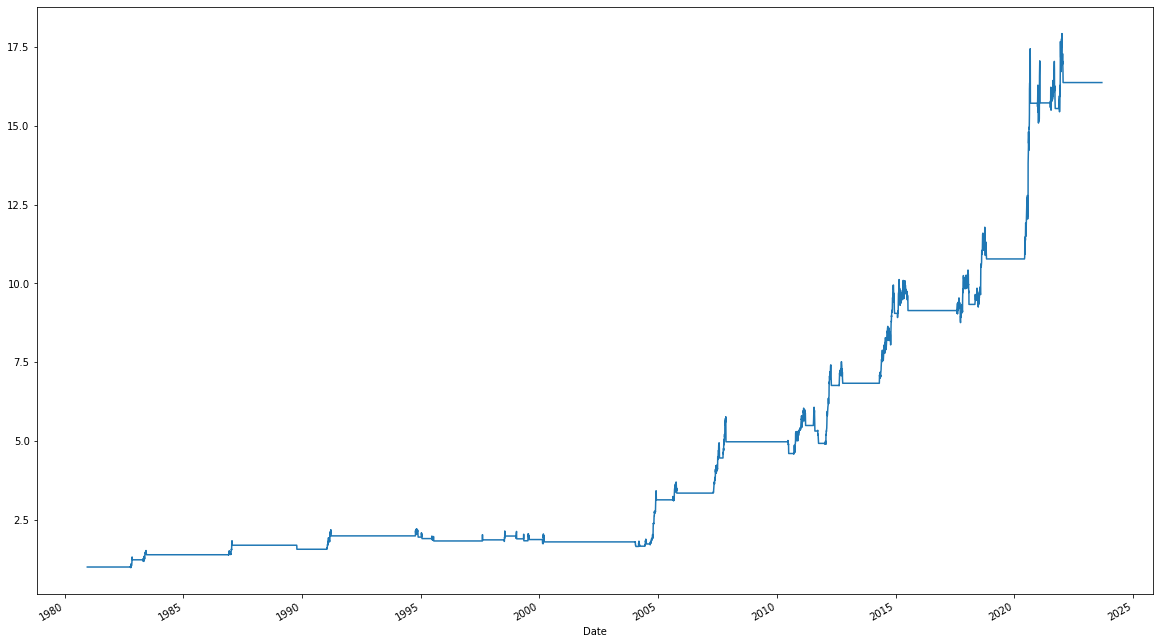

In [10]:
# df[["sReturn", "hReturn"]].plot(figsize=(20,12))
df["sReturn"].plot(figsize=(20,12))

In [214]:
# df[815:835]
# df.loc[(df["pos"] < 1) & (df["Strategy"] == -1), "Strategy"] = 0
# df["1994-01-10":"1994-02-25"]
trade = 2

date1 = (df.index[df['Strategy'] == 1].tolist()[trade] - timedelta(days=5)).strftime("%Y-%m-%d")
date2 = (df.index[df['Strategy'] == -1].tolist()[trade] + timedelta(days=5)).strftime("%Y-%m-%d")
df[date1:date2]
# date2

,Open,High,Close,Volume,High52,doh,Strategy,pos,trades,trade_high,Day profit,Hold,sReturn,hReturn
Date,,,,,,,,,,,,,,
2000-02-02,6.62,7.44,7.19,34600,9.25,2000-01-20,0,0.00,2,9.25,0.00,0.08,0.93,1.37
2000-02-03,7.41,7.75,7.69,29100,9.25,2000-01-20,0,0.00,2,9.25,0.00,0.07,0.93,1.46
2000-02-04,7.69,8.50,8.25,55800,9.25,2000-01-20,0,0.00,2,9.25,0.00,0.07,0.93,1.57
2000-02-07,8.44,11.62,11.00,464400,11.62,2000-02-07,1,0.00,3,11.62,0.00,0.29,0.93,2.10
2000-02-08,11.31,12.62,11.88,258400,12.62,2000-02-08,0,1.00,3,12.62,0.08,0.08,1.01,2.26
2000-02-09,13.12,13.12,12.88,97300,13.12,2000-02-09,0,1.00,3,13.12,0.08,0.08,1.09,2.45
2000-02-10,13.00,17.12,16.50,254700,17.12,2000-02-10,0,1.00,3,17.12,0.25,0.25,1.40,3.14
2000-02-11,16.50,18.00,17.62,199400,18.00,2000-02-11,0,1.00,3,18.00,0.07,0.07,1.50,3.36
2000-02-14,18.31,19.25,18.88,130500,19.25,2000-02-14,0,1.00,3,19.25,0.07,0.07,1.60,3.60


In [199]:
np.exp(df["Day profit"].sum())
df[["Day profit", "Hold"]].sum().apply(np.exp) * 100

Day profit   355.62
Hold         507.81
dtype: float64

In [14]:
df["sReturn"].nsmallest(10)

Date
1965-04-15   1.01
1965-04-20   1.02
1965-04-21   1.02
1965-04-22   1.02
1965-04-23   1.02
1965-04-26   1.02
1965-04-27   1.02
1965-04-28   1.02
1965-04-29   1.02
1965-04-30   1.02
Name: sReturn, dtype: float64

# Optimization

In [119]:
for ticker in mult_opt.columns.get_level_values(0).unique():
    print(ticker)
    display(mult_opt[ticker].sort_values("strategy return", ascending=False).head(5))

AAPL


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
23,17,210,5,3.40,80,"1,388.26"
20,17,195,5,3.40,80,"1,388.26"
17,17,180,5,3.40,80,"1,388.26"
29,17,240,5,3.35,81,"1,388.26"
26,17,225,5,3.35,81,"1,388.26"


In [119]:
mask = mult_opt["ABEO"]["time thresh1"] != 0
mult_opt["ABEO"][mask].sort_values("strategy return", ascending=False).head(20)
# mult_opt["EMO"].sort_values("strategy return", ascending=False).head(20)

,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
34,6,280,8,109.18,37,0.00
35,6,280,9,103.82,37,0.00
31,6,260,8,101.30,36,0.00
28,6,240,8,101.30,36,0.00
29,6,240,9,98.51,36,0.00
32,6,260,9,98.51,36,0.00
25,6,220,8,87.84,35,0.00
26,6,220,9,85.42,35,0.00
22,6,200,8,83.45,34,0.00
23,6,200,9,81.15,34,0.00


C:\Users\עידן\AppData\Local\Temp\ipykernel_42532\431642830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['return_mean'] = df.groupby(['time thresh1', 'time thresh2', "trail stop"])['strategy return'].transform('mean')


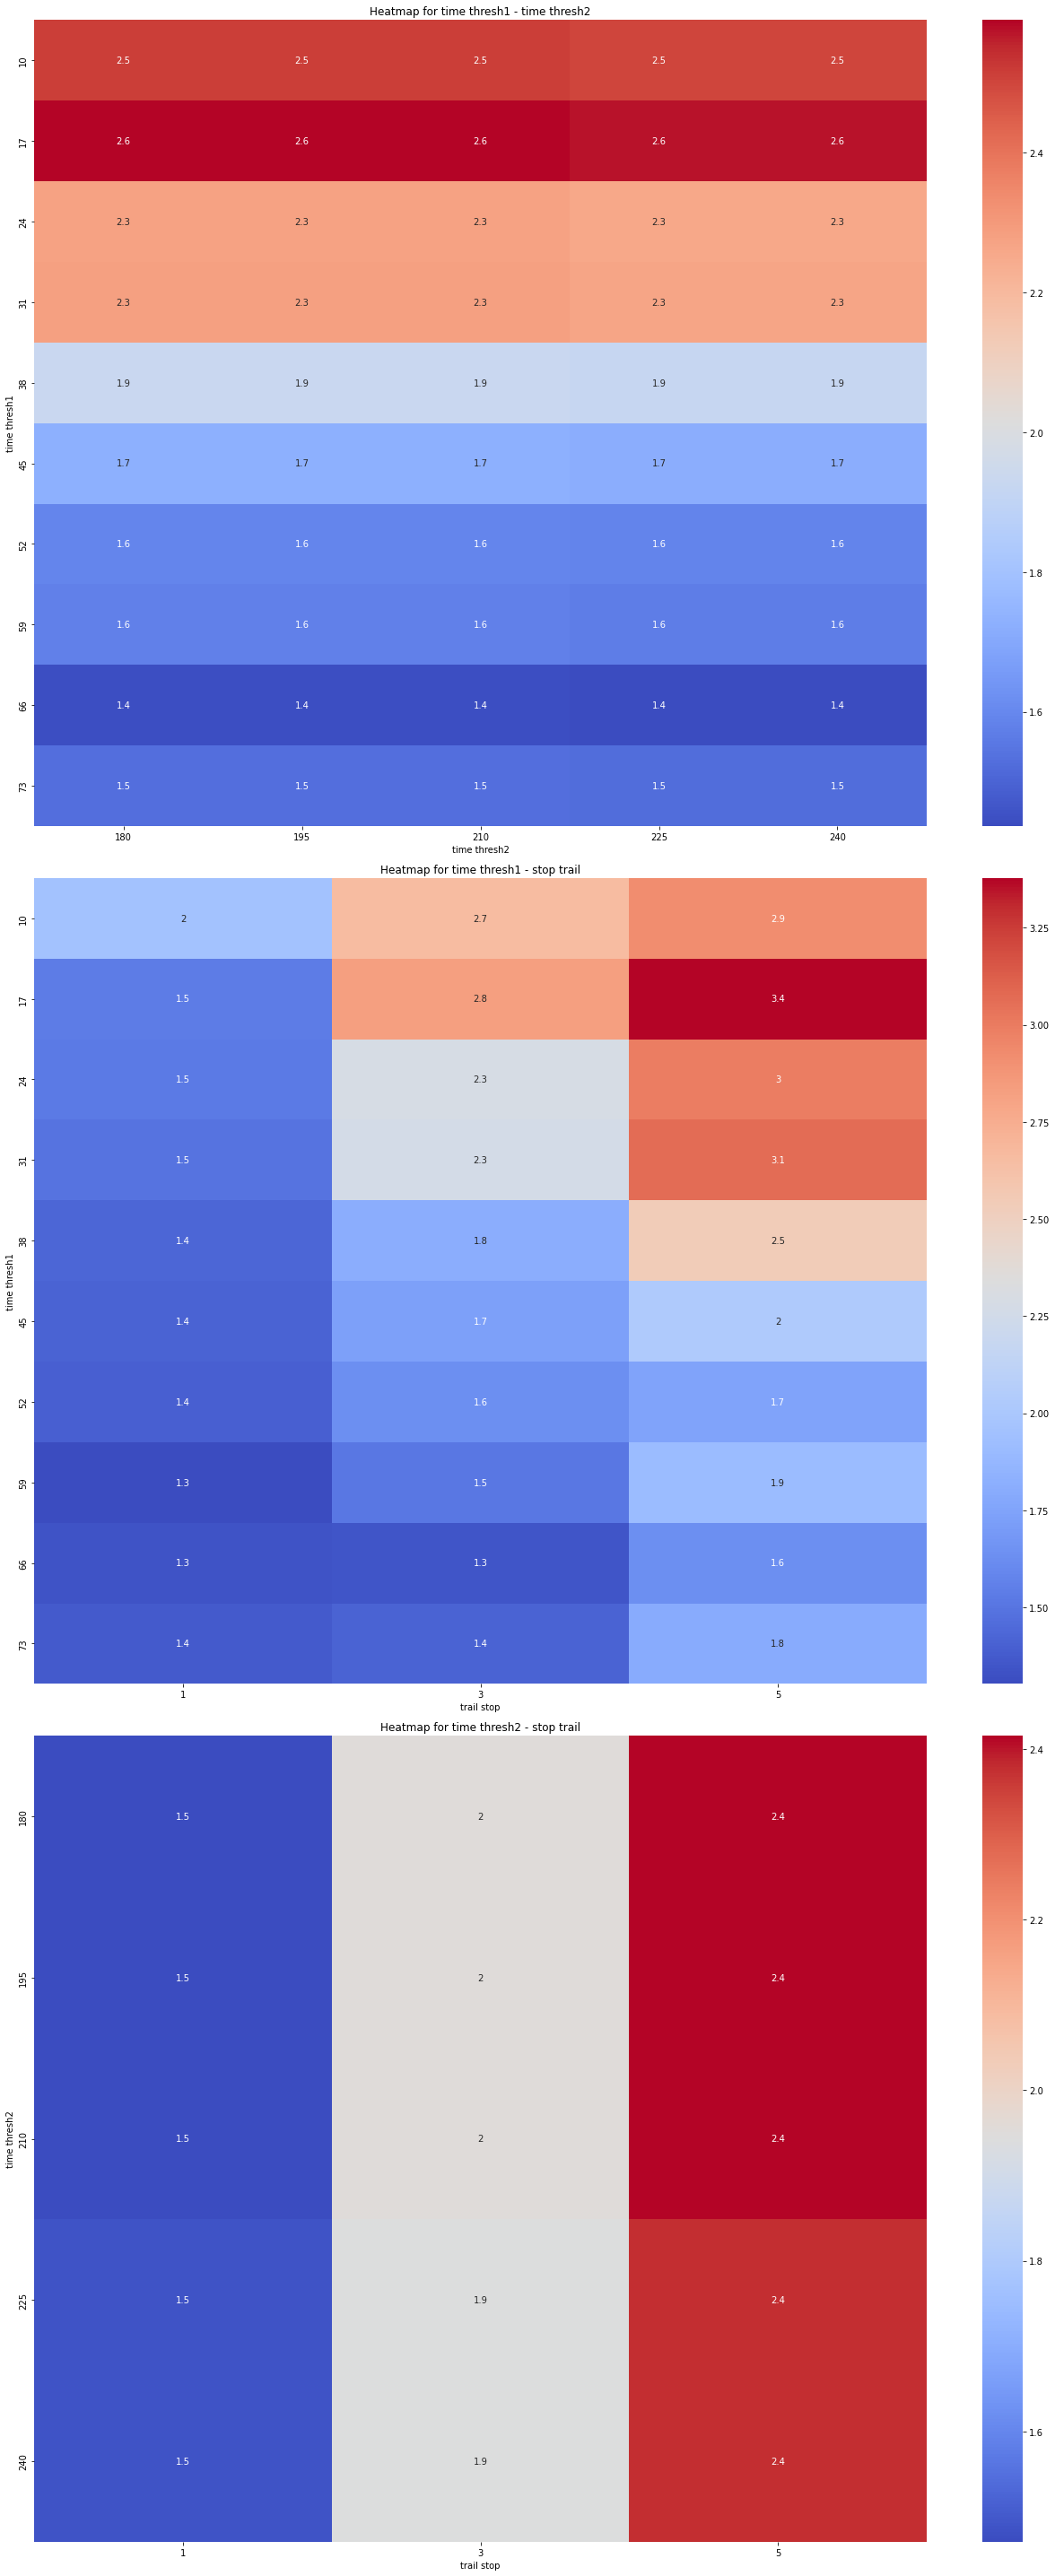

In [120]:
df = mult_opt["AAPL"]
df['return_mean'] = df.groupby(['time thresh1', 'time thresh2', "trail stop"])['strategy return'].transform('mean')
tt1_tt2 = df.pivot_table(values='return_mean', index='time thresh1', columns='time thresh2')
tt1_ts = df.pivot_table(values='return_mean', index='time thresh1', columns='trail stop')
tt2_ts = df.pivot_table(values='return_mean', index='time thresh2', columns='trail stop')

fig, ax = plt.subplots(3, 1, figsize=(18, 40))

sns.heatmap(tt1_tt2, annot=True, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Heatmap for time thresh1 - time thresh2')

sns.heatmap(tt1_ts, annot=True, cmap='coolwarm', ax=ax[1])
ax[1].set_title('Heatmap for time thresh1 - stop trail')

sns.heatmap(tt2_ts, annot=True, cmap='coolwarm', ax=ax[2])
ax[2].set_title('Heatmap for time thresh2 - stop trail')

plt.tight_layout()
plt.show()

In [140]:
mult_opt.to_csv("multi.csv")

In [238]:
# pd.read_csv("multi.csv", header=[0, 1], index_col=[0]).compare(mult_opt)
# mult_opt
tmp = pd.read_csv("multi.csv", header=[0, 1], index_col=[0])

In [255]:
tmp = mult_opt.copy()

AAPL                                                           
    time thresh1 time thresh2 trail stop strategy return Trades Hold return
0             15          160          9            8.21     44    1,383.43
1             15          170          9            7.88     45    1,383.43
2             15          180          9           10.16     46    1,383.43
3             15          190          9           10.16     46    1,383.43
4             15          200          9           10.16     46    1,383.43
..           ...          ...        ...             ...    ...         ...
149           65          250          9            3.37     18    1,383.43
150           65          260          9            3.37     18    1,383.43
151           65          270          9            3.37     18    1,383.43
152           65          280          9            3.37     18    1,383.43
153           65          290          9            3.37     18    1,383.43

[154 rows x 6 columns]

In [122]:
trades_sum = pd.DataFrame(columns=["Return", "Holding days"])
all_trades = trades
for _, trade in all_trades:
    if _ == 0:
        continue
        
    trade["prev close"] = trade["Close"].shift()
    trade["Change"] = trade["Close"].pct_change() + 1
    # total_return = (trade["Cumulative Return"].iloc[-1] - 1) * 100
    trade = trade[trade["pos"] == 1].copy()
    start_price = trade.iloc[0]["prev close"]
    end_price = trade.iloc[-1]["Close"]
    holding_days = len(trade)
    
    # Clear the trade signal
    trade = trade.drop(["hReturn", "Strategy", "pos", "High52", "Hold", "prev close", "trades", "doh", "trade_high"], axis=1)
    prcnt_chng = ((end_price - start_price) / start_price) * 100
    new_row = pd.DataFrame({"Return": [prcnt_chng], "Holding days": [holding_days]})
    # new_row = pd.DataFrame({"time thresh1": [tt1], "time thresh2": [tt2], "trail stop": [trs], "strategy return": [retrn], "Trades": [trades], "Hold return": [hold_r]})
    # results = pd.concat([results, new_row], ignore_index=True)
    trades_sum = pd.concat([trades_sum, new_row], ignore_index=True)
    display(trade)
    print(prcnt_chng)
    print(holding_days)
    print("------------------------------------------------------")

,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1982-10-11,0.10,0.11,0.11,313734400,0.02,1.02,1.02
1982-10-12,0.11,0.11,0.10,258944000,-0.03,0.99,0.97


-1.0637589202293374
2
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1982-12-02,0.15,0.15,0.15,164729600,0.00,0.99,1.00
1982-12-03,0.14,0.14,0.14,47577600,-0.02,0.97,0.98


-2.3075545268763995
2
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1982-12-07,0.15,0.15,0.15,167283200,0.01,0.98,1.01
1982-12-08,0.15,0.16,0.15,112313600,-0.02,0.96,0.98


-1.119993336255364
2
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1983-01-18,0.15,0.16,0.15,219788800,-0.02,0.93,0.98
1983-01-19,0.15,0.15,0.15,169657600,0.01,0.94,1.01
1983-01-20,0.15,0.17,0.17,707840000,0.11,1.05,1.11
1983-01-21,0.17,0.17,0.17,402595200,0.00,1.05,1.00
1983-01-24,0.17,0.17,0.16,315414400,-0.06,0.99,0.94


3.2964798325605
5
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1983-04-21,0.23,0.24,0.23,230048000,0.03,1.01,1.03
1983-04-22,0.23,0.23,0.23,127187200,-0.02,0.99,0.98
1983-04-25,0.23,0.23,0.22,125708800,-0.05,0.95,0.95


-3.9503728916549172
3
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1986-03-19,0.12,0.12,0.12,189884800,-0.01,0.93,0.99
1986-03-20,0.12,0.13,0.13,904131200,0.06,1.00,1.07
1986-03-21,0.13,0.13,0.12,260377600,-0.02,0.97,0.98


2.790511809006609
3
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1986-04-17,0.13,0.13,0.13,270099200,0.03,1.00,1.03
1986-04-18,0.13,0.13,0.13,247676800,0.03,1.03,1.03
1986-04-21,0.13,0.14,0.14,273548800,0.02,1.05,1.02
1986-04-22,0.14,0.14,0.13,327868800,-0.02,1.03,0.98
1986-04-23,0.13,0.14,0.13,261475200,-0.01,1.02,0.99


4.866957539202748
5
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1986-11-26,0.18,0.18,0.18,506240000,0.01,1.03,1.01
1986-11-28,0.18,0.18,0.18,220550400,-0.01,1.02,0.99
1986-12-01,0.18,0.18,0.18,347200000,0.00,1.02,1.00
1986-12-02,0.18,0.19,0.19,369600000,0.03,1.05,1.03
1986-12-03,0.19,0.19,0.19,336000000,0.03,1.09,1.03
1986-12-04,0.19,0.19,0.19,268800000,-0.01,1.08,0.99
1986-12-05,0.19,0.20,0.20,262080000,0.03,1.11,1.03
1986-12-08,0.19,0.20,0.19,347200000,-0.03,1.08,0.97
1986-12-09,0.19,0.19,0.19,302400000,-0.00,1.08,1.00


2.4843062967703373
12
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1987-01-07,0.20,0.20,0.20,434560000,0.02,1.07,1.02
1987-01-08,0.20,0.20,0.20,291200000,0.00,1.07,1.00
1987-01-09,0.20,0.20,0.20,239680000,0.01,1.09,1.01
1987-01-12,0.20,0.20,0.20,232960000,0.00,1.09,1.00
1987-01-13,0.20,0.20,0.20,211724800,-0.02,1.07,0.98
1987-01-14,0.20,0.22,0.21,504000000,0.08,1.15,1.08
1987-01-15,0.22,0.23,0.22,546560000,0.04,1.19,1.04
1987-01-16,0.22,0.22,0.22,407680000,-0.02,1.17,0.98


11.428322710954882
8
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1987-04-03,0.32,0.32,0.32,539840000,0.00,1.17,1.00
1987-04-06,0.32,0.32,0.31,288960000,-0.02,1.14,0.98
1987-04-07,0.31,0.31,0.30,259840000,-0.03,1.10,0.97


-5.5751712354417196
3
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1987-04-21,0.31,0.33,0.33,432320000,0.05,1.16,1.05
1987-04-22,0.34,0.34,0.33,403200000,-0.01,1.15,0.99
1987-04-23,0.33,0.34,0.34,304640000,0.02,1.18,1.02
1987-04-24,0.34,0.34,0.33,255360000,-0.02,1.16,0.98
1987-04-27,0.33,0.34,0.33,383040000,0.00,1.16,1.00
1987-04-28,0.34,0.35,0.34,324800000,0.03,1.19,1.03
1987-04-29,0.34,0.36,0.35,291200000,0.01,1.20,1.01
1987-04-30,0.35,0.36,0.35,253120000,0.02,1.23,1.02
1987-05-01,0.35,0.36,0.36,132720000,0.01,1.24,1.01


8.260218672888898
15
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1987-06-01,0.35,0.35,0.35,83305600,-0.02,1.17,0.98
1987-06-02,0.35,0.35,0.34,137491200,-0.01,1.17,0.99
1987-06-03,0.34,0.35,0.35,171315200,0.01,1.17,1.01
1987-06-04,0.35,0.35,0.35,153596800,0.01,1.19,1.01
1987-06-05,0.35,0.35,0.35,130928000,-0.01,1.17,0.99
1987-06-08,0.35,0.35,0.35,201846400,0.00,1.17,1.00
1987-06-09,0.35,0.35,0.35,127052800,0.01,1.19,1.01
1987-06-10,0.35,0.36,0.35,146227200,0.00,1.19,1.00
1987-06-11,0.35,0.36,0.35,125372800,0.01,1.19,1.01


2.5314721786751737
19
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1987-07-15,0.38,0.40,0.39,271040000,0.02,1.25,1.02
1987-07-16,0.39,0.39,0.39,94584000,0.00,1.25,1.00
1987-07-17,0.40,0.40,0.39,92198400,-0.02,1.23,0.98
1987-07-20,0.38,0.39,0.37,124320000,-0.04,1.19,0.97


-2.9070476894272237
4
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1987-08-07,0.41,0.42,0.42,152320000,0.01,1.19,1.01
1987-08-10,0.43,0.43,0.43,77996800,0.04,1.24,1.04
1987-08-11,0.44,0.45,0.44,271040000,0.03,1.27,1.03
1987-08-12,0.44,0.44,0.44,161280000,-0.02,1.25,0.98
1987-08-13,0.44,0.45,0.44,196000000,0.01,1.26,1.01
1987-08-14,0.43,0.45,0.44,104854400,0.00,1.26,1.00
1987-08-17,0.44,0.45,0.44,145600000,0.01,1.27,1.01
1987-08-18,0.44,0.44,0.44,237440000,-0.02,1.25,0.98
1987-08-19,0.44,0.45,0.45,66875200,0.03,1.28,1.03


12.432622064051186
19
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1989-05-25,0.42,0.44,0.43,232366400,0.01,1.35,1.01
1989-05-26,0.43,0.44,0.43,112515200,0.01,1.36,1.01
1989-05-30,0.43,0.44,0.42,111921600,-0.02,1.33,0.98
1989-05-31,0.42,0.43,0.43,115214400,0.01,1.34,1.01
1989-06-01,0.43,0.44,0.44,179502400,0.02,1.36,1.02
1989-06-02,0.43,0.44,0.44,124476800,0.01,1.37,1.01
1989-06-05,0.44,0.44,0.42,124118400,-0.04,1.31,0.96


-1.5705778234662977
7
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1989-10-10,0.44,0.45,0.44,287123200,0.00,1.31,1.00
1989-10-11,0.44,0.44,0.44,156956800,-0.01,1.30,0.99
1989-10-12,0.44,0.44,0.44,82644800,-0.00,1.29,1.00
1989-10-13,0.44,0.44,0.41,201118400,-0.06,1.21,0.94


-7.575733566035154
4
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1991-01-17,0.47,0.47,0.46,591673600,0.03,1.25,1.03
1991-01-18,0.44,0.45,0.45,943241600,-0.02,1.23,0.98
1991-01-21,0.44,0.46,0.45,324307200,0.01,1.24,1.01
1991-01-22,0.46,0.47,0.46,427728000,0.01,1.25,1.01
1991-01-23,0.46,0.47,0.46,244260800,0.01,1.26,1.01
1991-01-24,0.46,0.47,0.47,233934400,0.01,1.27,1.01
1991-01-25,0.46,0.48,0.48,223809600,0.03,1.31,1.03
1991-01-28,0.48,0.49,0.49,273481600,0.02,1.33,1.02
1991-01-29,0.48,0.49,0.48,215555200,-0.01,1.31,0.99


14.824313654766563
21
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1991-03-06,0.57,0.59,0.56,523958400,-0.00,1.39,1.00
1991-03-07,0.57,0.60,0.60,321753600,0.07,1.49,1.07
1991-03-08,0.60,0.61,0.58,322201600,-0.03,1.44,0.97
1991-03-11,0.58,0.58,0.57,175369600,-0.02,1.40,0.98


0.5940202246066929
4
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1994-10-11,0.37,0.37,0.35,842307200,0.02,1.43,1.02


1.9294260439631017
1
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1995-01-11,0.39,0.43,0.42,873824000,0.07,1.53,1.07
1995-01-12,0.41,0.41,0.41,551779200,-0.03,1.49,0.97


3.8626648463377364
2
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1995-06-21,0.43,0.45,0.44,626012800,0.04,1.55,1.04
1995-06-22,0.44,0.44,0.44,473916800,-0.01,1.54,0.99
1995-06-23,0.44,0.44,0.44,231963200,-0.01,1.53,0.99
1995-06-26,0.43,0.43,0.43,152779200,-0.01,1.51,0.99
1995-06-27,0.42,0.43,0.41,217100800,-0.04,1.45,0.96


-2.1106833874166564
5
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1995-07-11,0.43,0.43,0.42,214692800,-0.03,1.41,0.97


-3.084867615558889
1
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1995-07-18,0.44,0.44,0.43,254632000,-0.02,1.38,0.98
1995-07-19,0.42,0.43,0.41,521035200,-0.06,1.31,0.95


-7.142857142857142
2
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1997-08-08,0.25,0.25,0.24,1814164800,-0.08,1.20,0.92


-8.137283738389407
1
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1998-07-09,0.29,0.30,0.28,566608000,-0.03,1.17,0.97


-2.687310716041132
1
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1998-08-11,0.34,0.37,0.35,1759475200,0.03,1.20,1.03
1998-08-12,0.35,0.37,0.36,689774400,0.03,1.24,1.03
1998-08-13,0.36,0.36,0.35,390779200,-0.02,1.22,0.98
1998-08-14,0.36,0.36,0.36,450777600,0.03,1.25,1.03
1998-08-17,0.37,0.38,0.37,930876800,0.03,1.29,1.04
1998-08-18,0.38,0.39,0.38,605953600,0.01,1.31,1.01
1998-08-19,0.39,0.39,0.37,485990400,-0.04,1.26,0.96


8.072250974104302
7
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1999-01-06,0.39,0.39,0.37,1348569600,-0.04,1.22,0.96


-3.60752230093766
1
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1999-05-03,0.41,0.45,0.44,1470436800,0.07,1.31,1.08
1999-05-04,0.43,0.43,0.42,811238400,-0.06,1.23,0.94


1.087134535810366
2
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1999-07-08,0.46,0.49,0.49,1625041600,0.09,1.35,1.09
1999-07-09,0.49,0.50,0.50,608697600,0.02,1.37,1.02
1999-07-12,0.50,0.50,0.49,303912000,-0.02,1.35,0.98
1999-07-13,0.48,0.48,0.48,283259200,-0.02,1.33,0.99
1999-07-14,0.49,0.51,0.50,624556800,0.04,1.38,1.04
1999-07-15,0.50,0.50,0.48,1691804800,-0.05,1.32,0.95


6.766696392270896
6
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1999-08-03,0.51,0.51,0.49,368379200,-0.01,1.30,0.99
1999-08-04,0.49,0.50,0.48,371425600,-0.03,1.27,0.97


-3.475318972097474
2
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1999-08-11,0.50,0.53,0.53,850337600,0.07,1.37,1.08
1999-08-12,0.53,0.55,0.54,666108800,0.01,1.38,1.01
1999-08-13,0.54,0.55,0.54,298435200,0.00,1.38,1.00
1999-08-16,0.53,0.54,0.54,276931200,0.01,1.39,1.01
1999-08-17,0.54,0.54,0.54,320936000,-0.00,1.38,1.00
1999-08-18,0.54,0.55,0.54,468574400,-0.00,1.38,1.00
1999-08-19,0.53,0.54,0.52,550020800,-0.02,1.35,0.98


6.094822767137421
7
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
1999-11-01,0.71,0.72,0.69,278577600,-0.03,1.31,0.97
1999-11-02,0.70,0.73,0.72,399235200,0.03,1.35,1.03
1999-11-03,0.73,0.74,0.73,328462400,0.02,1.37,1.02
1999-11-04,0.73,0.76,0.75,379086400,0.03,1.41,1.03
1999-11-05,0.76,0.79,0.79,416808000,0.05,1.48,1.06
1999-11-08,0.78,0.87,0.86,950924800,0.09,1.62,1.09
1999-11-09,0.84,0.84,0.80,809177600,-0.07,1.51,0.93


11.856408697754643
7
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2000-02-16,1.05,1.05,1.02,378246400,-0.04,1.45,0.96
2000-02-17,1.03,1.03,1.03,289497600,0.01,1.45,1.01
2000-02-18,1.02,1.03,0.99,233441600,-0.03,1.41,0.97


-6.512563368853401
3
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2000-03-22,1.19,1.29,1.29,567996800,0.07,1.51,1.07
2000-03-23,1.27,1.34,1.26,562564800,-0.02,1.48,0.98


4.724433678748325
2
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2003-08-22,0.39,0.39,0.37,250264000,-0.04,1.42,0.96


-3.6901047337938127
1
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2003-10-08,0.42,0.42,0.41,428668800,-0.01,1.41,0.99
2003-10-09,0.42,0.42,0.42,347748800,0.02,1.43,1.02
2003-10-10,0.42,0.43,0.42,174837600,0.01,1.45,1.01
2003-10-13,0.42,0.44,0.43,279865600,0.03,1.49,1.03
2003-10-14,0.43,0.44,0.44,275419200,0.01,1.50,1.01
2003-10-15,0.44,0.45,0.44,610103200,0.01,1.52,1.01
2003-10-16,0.43,0.43,0.42,975682400,-0.07,1.42,0.94


0.12927375690984977
7
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2004-01-14,0.44,0.44,0.43,620043200,0.00,1.43,1.00
2004-01-15,0.41,0.42,0.41,1018208800,-0.06,1.35,0.94


-5.2652147427230584
2
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2004-03-05,0.45,0.49,0.48,1540599200,0.06,1.43,1.06
2004-03-08,0.48,0.48,0.46,522872000,-0.03,1.39,0.97


3.3386273404390177
2
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2004-03-30,0.50,0.50,0.50,359676800,0.00,1.39,1.00
2004-03-31,0.50,0.50,0.48,390773600,-0.03,1.35,0.97
2004-04-01,0.48,0.49,0.48,318332000,0.00,1.35,1.00
2004-04-02,0.50,0.50,0.49,274478400,0.01,1.37,1.01
2004-04-05,0.49,0.51,0.51,385672000,0.03,1.41,1.03
2004-04-06,0.49,0.50,0.50,257992000,-0.02,1.39,0.98
2004-04-07,0.49,0.49,0.49,255119200,-0.02,1.36,0.98
2004-04-08,0.50,0.50,0.49,240917600,0.01,1.37,1.01
2004-04-12,0.49,0.50,0.50,230540800,0.02,1.40,1.02


-3.5112879077531014
10
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2004-06-08,0.54,0.54,0.54,415620800,0.02,1.37,1.02
2004-06-09,0.54,0.55,0.54,349204800,-0.00,1.36,1.00
2004-06-10,0.54,0.55,0.55,257577600,0.02,1.39,1.02
2004-06-14,0.55,0.55,0.54,243986400,-0.02,1.36,0.98
2004-06-15,0.55,0.56,0.55,444634400,0.02,1.38,1.02
2004-06-16,0.55,0.60,0.58,909641600,0.06,1.48,1.07
2004-06-17,0.58,0.59,0.59,551320000,0.00,1.48,1.00
2004-06-18,0.58,0.60,0.59,406252000,0.00,1.48,1.00
2004-06-21,0.59,0.60,0.58,390213600,-0.02,1.46,0.98


8.353044005596772
17
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2004-08-27,0.62,0.62,0.61,388813600,-0.01,1.44,0.99
2004-08-30,0.61,0.62,0.61,218142400,-0.01,1.43,0.99
2004-08-31,0.61,0.62,0.62,376560800,0.01,1.45,1.01
2004-09-01,0.61,0.64,0.64,515726400,0.04,1.51,1.04
2004-09-02,0.63,0.64,0.64,406324800,-0.01,1.50,0.99
2004-09-03,0.63,0.64,0.63,293468000,-0.01,1.48,0.99
2004-09-07,0.63,0.65,0.64,301957600,0.01,1.50,1.02
2004-09-08,0.64,0.65,0.65,343526400,0.02,1.53,1.02
2004-09-09,0.64,0.65,0.64,461339200,-0.02,1.50,0.98


6.520455789950333
18
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2005-01-10,1.25,1.26,1.23,1725309600,-0.00,1.54,1.00
2005-01-11,1.22,1.23,1.15,2611627200,-0.07,1.45,0.94


-6.772564974047592
2
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2005-08-15,1.66,1.73,1.70,1086727600,0.03,1.50,1.03
2005-08-16,1.69,1.70,1.65,537622400,-0.03,1.45,0.97
2005-08-17,1.66,1.69,1.68,499724400,0.02,1.48,1.02
2005-08-18,1.68,1.68,1.65,442559600,-0.02,1.45,0.98
2005-08-19,1.65,1.67,1.64,376569200,-0.01,1.44,0.99


-0.5856893298628285
5
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2005-09-07,1.75,1.76,1.74,963074000,-0.00,1.43,1.00
2005-09-08,1.76,1.79,1.78,702640400,0.02,1.47,1.02
2005-09-09,1.79,1.83,1.83,615641600,0.03,1.51,1.03
2005-09-12,1.83,1.84,1.84,452796400,0.00,1.51,1.00
2005-09-13,1.82,1.83,1.82,492884000,-0.01,1.50,0.99
2005-09-14,1.82,1.83,1.77,474426400,-0.02,1.46,0.98
2005-09-15,1.79,1.79,1.78,415156000,0.01,1.47,1.01
2005-09-16,1.79,1.83,1.83,591004400,0.03,1.51,1.03
2005-09-19,1.82,1.89,1.88,783731200,0.03,1.55,1.03


4.672156443876339
16
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2006-01-05,2.67,2.67,2.66,449422400,-0.01,1.49,0.99
2006-01-06,2.69,2.74,2.72,704457600,0.03,1.53,1.03
2006-01-09,2.74,2.76,2.72,675040800,-0.00,1.53,1.00
2006-01-10,2.72,2.92,2.89,2279869200,0.06,1.62,1.06
2006-01-11,2.99,3.03,3.00,1493794400,0.04,1.68,1.04
2006-01-12,3.03,3.09,3.01,1280809600,0.00,1.69,1.00
2006-01-13,3.04,3.07,3.06,776305600,0.02,1.72,1.02
2006-01-17,3.06,3.09,3.03,835623600,-0.01,1.70,0.99
2006-01-18,2.97,3.00,2.95,1200637200,-0.03,1.66,0.97


5.428828871025033
10
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2007-01-10,3.38,3.49,3.46,2952880000,0.05,1.66,1.05
2007-01-11,3.43,3.46,3.42,1440252800,-0.01,1.64,0.99
2007-01-12,3.38,3.39,3.38,1312690400,-0.01,1.62,0.99
2007-01-16,3.42,3.47,3.47,1244076400,0.03,1.66,1.03
2007-01-17,3.48,3.49,3.39,1646260000,-0.02,1.63,0.98
2007-01-18,3.29,3.29,3.18,2364605600,-0.06,1.53,0.94


-3.780922986035505
6
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2007-04-27,3.51,3.57,3.57,699403600,0.01,1.54,1.01
2007-04-30,3.57,3.61,3.56,616509600,-0.00,1.54,1.00
2007-05-01,3.56,3.58,3.55,532523600,-0.00,1.54,1.00
2007-05-02,3.56,3.59,3.59,505145200,0.01,1.55,1.01
2007-05-03,3.60,3.62,3.59,576077600,0.00,1.55,1.00
2007-05-04,3.60,3.63,3.60,381987200,0.00,1.56,1.00
2007-05-07,3.61,3.73,3.71,861557200,0.03,1.60,1.03
2007-05-08,3.70,3.76,3.75,783997200,0.01,1.62,1.01
2007-05-09,3.75,3.82,3.82,717757600,0.02,1.65,1.02


21.60056809812147
31
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2007-09-25,5.24,5.47,5.47,1192550800,0.03,1.92,1.03
2007-09-26,5.52,5.54,5.46,975268000,-0.00,1.91,1.00
2007-09-27,5.49,5.52,5.52,658198800,0.01,1.93,1.01
2007-09-28,5.48,5.52,5.48,615101200,-0.01,1.92,0.99
2007-10-01,5.52,5.62,5.58,837068400,0.02,1.96,1.02
2007-10-02,5.59,5.66,5.66,792069600,0.01,1.98,1.01
2007-10-03,5.64,5.68,5.64,692518400,-0.00,1.98,1.00
2007-10-04,5.64,5.65,5.58,656958400,-0.01,1.96,0.99
2007-10-05,5.66,5.77,5.77,943471200,0.03,2.02,1.03


9.407894908632938
13
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2007-12-10,6.91,6.99,6.94,722377600,-0.00,2.03,1.00
2007-12-11,6.96,7.03,6.73,1110925200,-0.03,1.97,0.97
2007-12-12,6.91,6.95,6.82,1225660800,0.01,1.99,1.01
2007-12-13,6.79,6.86,6.85,864617600,0.01,2.00,1.01
2007-12-14,6.80,6.90,6.80,674312800,-0.01,1.99,0.99
2007-12-17,6.81,6.88,6.59,1024693600,-0.03,1.93,0.97


-5.095226753893322
6
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2009-11-17,7.36,7.41,7.39,396513600,0.00,1.93,1.00
2009-11-18,7.38,7.39,7.36,374320800,-0.01,1.92,0.99
2009-11-19,7.31,7.31,7.16,542326400,-0.03,1.87,0.97
2009-11-20,7.11,7.16,7.14,406666400,-0.00,1.86,1.00
2009-11-23,7.25,7.36,7.35,474896800,0.03,1.92,1.03
2009-11-24,7.33,7.35,7.30,318438400,-0.01,1.91,0.99
2009-11-25,7.34,7.34,7.29,286454000,-0.00,1.90,1.00
2009-11-27,7.11,7.25,7.16,295257200,-0.02,1.87,0.98
2009-11-30,7.18,7.20,7.14,424858000,-0.00,1.86,1.00


-4.675020077560218
10
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2009-12-28,7.56,7.64,7.56,644565600,0.01,1.86,1.01
2009-12-29,7.59,7.60,7.47,445205600,-0.01,1.84,0.99
2009-12-30,7.46,7.57,7.56,412084400,0.01,1.86,1.01
2009-12-31,7.61,7.62,7.53,352410800,-0.00,1.85,1.00
2010-01-04,7.62,7.66,7.64,493729600,0.02,1.88,1.02
2010-01-05,7.66,7.70,7.66,601904800,0.00,1.88,1.00
2010-01-06,7.66,7.69,7.53,552160000,-0.02,1.85,0.98
2010-01-07,7.56,7.57,7.52,477131200,-0.00,1.85,1.00
2010-01-08,7.51,7.57,7.57,447610800,0.01,1.86,1.01


-5.400876312861358
18
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2010-03-08,7.86,7.86,7.82,429889600,0.00,1.74,1.00
2010-03-09,7.80,8.04,7.97,920259200,0.02,1.77,1.02
2010-03-10,7.99,8.05,8.03,596218000,0.01,1.78,1.01
2010-03-11,8.00,8.05,8.05,405700400,0.00,1.79,1.00
2010-03-12,8.12,8.13,8.09,416323600,0.00,1.80,1.00
2010-03-15,8.05,8.05,7.99,493502800,-0.01,1.78,0.99
2010-03-16,8.01,8.03,8.02,446908000,0.00,1.78,1.00
2010-03-17,8.03,8.09,8.00,450956800,-0.00,1.78,1.00
2010-03-18,8.00,8.04,8.02,342109600,0.00,1.78,1.00


18.145689548984144
41
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2010-06-18,9.72,9.82,9.79,784621600,0.01,2.07,1.01
2010-06-21,9.92,9.96,9.65,776490400,-0.01,2.04,0.99
2010-06-22,9.72,9.86,9.78,717262000,0.01,2.07,1.01
2010-06-23,9.81,9.81,9.68,768457200,-0.01,2.05,0.99
2010-06-24,9.68,9.76,9.61,714277200,-0.01,2.03,0.99
2010-06-25,9.65,9.65,9.52,549942400,-0.01,2.01,0.99
2010-06-28,9.53,9.63,9.58,584948000,0.01,2.03,1.01
2010-06-29,9.43,9.44,9.15,1133344800,-0.05,1.93,0.95


-5.77482303584248
8
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2010-09-17,9.92,9.93,9.83,634477200,-0.00,1.93,1.00
2010-09-20,9.86,10.14,10.12,658677600,0.03,1.98,1.03
2010-09-21,10.14,10.26,10.13,668074400,0.00,1.99,1.00
2010-09-22,10.10,10.28,10.28,585289600,0.01,2.01,1.01
2010-09-23,10.23,10.46,10.32,786116800,0.00,2.02,1.00
2010-09-24,10.43,10.48,10.44,649488000,0.01,2.04,1.01
2010-09-27,10.50,10.53,10.40,482834800,-0.00,2.04,1.00
2010-09-28,10.42,10.42,10.24,1035042400,-0.01,2.01,0.99
2010-09-29,10.26,10.35,10.26,469644000,0.00,2.01,1.00


0.7484666142527948
12
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2010-12-03,11.32,11.38,11.34,342092800,-0.00,1.94,1.00
2010-12-06,11.38,11.51,11.43,448481600,0.01,1.96,1.01
2010-12-07,11.56,11.57,11.36,391454000,-0.01,1.95,0.99
2010-12-08,11.42,11.47,11.46,321935600,0.01,1.97,1.01
2010-12-09,11.50,11.52,11.42,294151200,-0.00,1.96,1.00
2010-12-10,11.42,11.47,11.45,262511200,0.00,1.96,1.00
2010-12-13,11.58,11.61,11.49,439815600,0.00,1.97,1.00
2010-12-14,11.49,11.52,11.44,351008000,-0.00,1.96,1.00
2010-12-15,11.43,11.54,11.44,417312000,0.00,1.96,1.00


2.693696601058631
34
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2011-02-08,12.63,12.70,12.69,381040800,0.01,2.02,1.01
2011-02-09,12.69,12.82,12.79,482745200,0.01,2.04,1.01
2011-02-10,12.76,12.86,12.66,928550000,-0.01,2.02,0.99
2011-02-11,12.67,12.78,12.74,367572800,0.01,2.03,1.01
2011-02-14,12.74,12.84,12.83,310416400,0.01,2.04,1.01
2011-02-15,12.83,12.86,12.85,284174800,0.00,2.05,1.00
2011-02-16,12.89,13.03,12.97,481157600,0.01,2.07,1.01
2011-02-17,12.76,12.87,12.80,530583200,-0.01,2.04,0.99
2011-02-18,12.81,12.84,12.52,816057200,-0.02,1.99,0.98


-3.771178450105311
10
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2011-07-18,13.05,13.38,13.35,572653200,0.02,1.97,1.02
2011-07-19,13.50,13.52,13.46,819145600,0.01,1.99,1.01
2011-07-20,14.15,14.15,13.82,941340400,0.03,2.04,1.03
2011-07-21,13.82,13.93,13.83,526534400,0.00,2.04,1.00
2011-07-22,13.87,14.11,14.05,516728800,0.02,2.08,1.02
2011-07-25,13.94,14.29,14.23,589806000,0.01,2.10,1.01
2011-07-26,14.29,14.45,14.41,476582400,0.01,2.13,1.01
2011-07-27,14.31,14.38,14.02,659324400,-0.03,2.07,0.97
2011-07-28,13.99,14.18,13.99,594034000,-0.00,2.07,1.00


3.4117079826409316
14
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2011-09-20,14.83,15.10,14.77,775754000,0.00,2.00,1.00
2011-09-21,14.99,15.06,14.72,605976000,-0.00,1.99,1.00
2011-09-22,14.32,14.64,14.35,968480800,-0.03,1.94,0.97
2011-09-23,14.30,14.53,14.44,546277200,0.01,1.96,1.01
2011-09-26,14.28,14.43,14.40,812876400,-0.00,1.95,1.00
2011-09-27,14.60,14.62,14.26,632497600,-0.01,1.93,0.99


-3.0051202742230227
6
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2011-10-17,15.06,15.24,15.00,686044800,-0.00,1.92,1.00
2011-10-18,15.06,15.17,15.08,881602400,0.01,1.93,1.01
2011-10-19,14.33,14.59,14.24,1104059600,-0.06,1.82,0.94


-5.540284362888591
3
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2012-01-09,15.20,15.28,15.06,394024400,-0.00,1.82,1.00
2012-01-10,15.21,15.21,15.12,258196400,0.00,1.83,1.00
2012-01-11,15.10,15.10,15.09,215084800,-0.00,1.83,1.00
2012-01-12,15.08,15.10,15.05,212587200,-0.00,1.82,1.00
2012-01-13,14.99,15.02,14.99,226021600,-0.00,1.81,1.00
2012-01-17,15.15,15.21,15.17,242897200,0.01,1.83,1.01
2012-01-18,15.25,15.34,15.33,276791200,0.01,1.85,1.01
2012-01-19,15.36,15.41,15.28,261738400,-0.00,1.85,1.00
2012-01-20,15.27,15.27,15.01,413974400,-0.02,1.82,0.98


17.8196086384325
27
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2012-08-15,22.55,22.64,22.53,257342400,-0.00,2.15,1.00
2012-08-16,22.54,22.74,22.73,254534000,0.01,2.17,1.01
2012-08-17,22.86,23.15,23.15,442761200,0.02,2.21,1.02
2012-08-20,23.21,23.76,23.76,613384800,0.03,2.26,1.03
2012-08-21,23.96,24.10,23.43,812719600,-0.01,2.23,0.99
2012-08-22,23.37,23.89,23.89,565322800,0.02,2.28,1.02
2012-08-23,23.79,23.92,23.67,420128800,-0.01,2.26,0.99
2012-08-24,23.55,23.91,23.69,437340400,0.00,2.26,1.00
2012-08-27,24.29,24.32,24.13,427008400,0.02,2.30,1.02


5.3016606860056585
30
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2013-12-24,20.35,20.42,20.27,167554800,-0.00,2.25,1.00
2013-12-26,20.29,20.34,20.14,204008000,-0.01,2.24,0.99
2013-12-27,20.14,20.16,20.00,225884400,-0.01,2.22,0.99
2013-12-30,19.91,20.00,19.80,253629600,-0.01,2.20,0.99
2013-12-31,19.79,20.05,20.04,223084400,0.01,2.23,1.01
2014-01-02,19.85,19.89,19.75,234684800,-0.01,2.20,0.99
2014-01-03,19.75,19.77,19.32,392467600,-0.02,2.15,0.98


-5.10620869494021
7
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2014-04-28,20.46,21.28,21.22,669485600,0.04,2.23,1.04
2014-04-29,21.20,21.28,21.15,337377600,-0.00,2.23,1.00
2014-04-30,21.17,21.41,21.07,456640800,-0.00,2.22,1.00
2014-05-01,21.14,21.24,21.12,244048000,0.00,2.22,1.00
2014-05-02,21.16,21.22,21.16,191514400,0.00,2.23,1.00
2014-05-05,21.08,21.46,21.46,287067200,0.01,2.26,1.01
2014-05-06,21.49,21.59,21.23,374564400,-0.01,2.23,0.99
2014-05-07,21.26,21.33,21.15,282864400,-0.00,2.23,1.00
2014-05-08,21.01,21.23,21.00,230297200,-0.01,2.21,0.99


10.494099912114033
41
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2014-07-08,24.07,24.20,23.84,260888000,-0.01,2.36,0.99
2014-07-09,23.86,23.99,23.85,145744000,0.00,2.36,1.00
2014-07-10,23.44,23.89,23.76,158744000,-0.00,2.35,1.00
2014-07-11,23.84,23.97,23.81,136072000,0.00,2.36,1.00
2014-07-14,23.97,24.22,24.11,171240000,0.01,2.39,1.01
2014-07-15,24.20,24.21,23.83,181911600,-0.01,2.36,0.99
2014-07-16,24.24,24.27,23.69,213585200,-0.01,2.34,0.99
2014-07-17,23.76,23.82,23.27,229192000,-0.02,2.30,0.98
2014-07-18,23.41,23.68,23.61,199952000,0.01,2.34,1.01


2.240284983361131
42
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2014-10-23,26.02,26.26,26.21,284298800,0.02,2.47,1.02
2014-10-24,26.30,26.37,26.31,188215600,0.00,2.48,1.00
2014-10-27,26.21,26.37,26.28,136750800,-0.00,2.48,1.00
2014-10-28,26.35,26.68,26.68,192243600,0.02,2.52,1.02
2014-10-29,26.66,26.84,26.83,210751600,0.01,2.53,1.01
2014-10-30,26.74,26.84,26.75,162619200,-0.00,2.52,1.00
2014-10-31,27.00,27.01,27.00,178557200,0.01,2.55,1.01
2014-11-03,27.06,27.58,27.35,209130400,0.01,2.58,1.01
2014-11-04,27.34,27.37,27.15,166297600,-0.01,2.56,0.99


9.136813144278824
32
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2015-01-30,29.60,30.00,29.29,334982000,-0.01,2.61,0.99
2015-02-02,29.51,29.79,29.66,250956400,0.01,2.64,1.01
2015-02-03,29.62,29.77,29.66,207662800,0.00,2.64,1.00
2015-02-04,29.62,30.13,29.89,280598800,0.01,2.66,1.01
2015-02-05,30.00,30.06,29.99,168984800,0.00,2.67,1.00
2015-02-06,30.00,30.06,29.73,174826400,-0.01,2.65,0.99
2015-02-09,29.64,29.96,29.93,155559200,0.01,2.67,1.01
2015-02-10,30.04,30.54,30.50,248034000,0.02,2.72,1.02
2015-02-11,30.69,31.23,31.22,294247200,0.02,2.78,1.02


6.316233843441875
24
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2015-04-28,33.62,33.63,32.64,475696000,-0.02,2.77,0.98
2015-04-29,32.54,32.90,32.16,253544400,-0.01,2.73,0.99
2015-04-30,32.16,32.16,31.29,332781600,-0.03,2.66,0.97


-5.6539711388590135
3
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2017-01-10,29.69,29.84,29.78,97848400,0.00,2.66,1.00
2017-01-11,29.68,29.98,29.94,110354400,0.01,2.67,1.01
2017-01-12,29.73,29.83,29.81,108344800,-0.00,2.66,1.00
2017-01-13,29.78,29.91,29.76,104447600,-0.00,2.66,1.00
2017-01-17,29.58,30.06,30.00,137759200,0.01,2.68,1.01
...,...,...,...,...,...,...,...
2017-06-06,38.47,38.95,38.61,106499600,0.00,3.45,1.00
2017-06-07,38.76,38.99,38.84,84278400,0.01,3.47,1.01
2017-06-08,38.81,38.88,38.75,85003200,-0.00,3.46,1.00


22.211951239326204
106
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2017-08-03,39.26,39.30,38.89,108389200,-0.01,3.21,0.99
2017-08-04,39.02,39.35,39.10,82239600,0.01,3.23,1.01
2017-08-07,39.26,39.73,39.70,87481200,0.02,3.28,1.02
2017-08-08,39.65,40.46,40.02,144823600,0.01,3.31,1.01
2017-08-09,39.81,40.32,40.26,104526000,0.01,3.33,1.01
2017-08-10,39.97,40.00,38.83,163217200,-0.04,3.21,0.96
2017-08-11,39.15,39.64,39.37,105028400,0.01,3.25,1.01
2017-08-14,39.83,40.05,39.96,88490800,0.01,3.30,1.02
2017-08-15,40.17,40.55,40.40,117862000,0.01,3.34,1.01


-0.6809164245804197
34
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2017-10-31,41.97,42.41,42.26,144187200,0.01,3.27,1.01
2017-11-01,42.47,42.49,41.72,134551200,-0.01,3.23,0.99
2017-11-02,41.65,42.12,42.03,165573600,0.01,3.25,1.01
2017-11-03,43.50,43.56,43.12,237594400,0.03,3.34,1.03
2017-11-06,43.09,43.75,43.56,140105200,0.01,3.37,1.01
...,...,...,...,...,...,...,...
2018-01-23,44.33,44.86,44.26,130756400,0.00,3.42,1.00
2018-01-24,44.31,44.33,43.56,204420400,-0.02,3.37,0.98
2018-01-25,43.63,43.74,42.78,166116000,-0.02,3.31,0.98


0.7437652855595588
61
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2018-02-27,44.78,45.12,44.60,155712400,-0.00,3.24,1.00
2018-02-28,44.81,45.15,44.53,151128400,-0.00,3.23,1.00
2018-03-01,44.63,44.94,43.75,195208000,-0.02,3.18,0.98
2018-03-02,43.20,44.08,44.05,153816000,0.01,3.20,1.01
2018-03-05,43.80,44.44,44.21,113605600,0.00,3.21,1.00
2018-03-06,44.48,44.56,44.17,95154000,-0.00,3.21,1.00
2018-03-07,43.74,43.96,43.76,126814000,-0.01,3.18,0.99
2018-03-08,43.87,44.28,44.24,95096400,0.01,3.21,1.01
2018-03-09,44.49,45.00,44.99,128740800,0.02,3.27,1.02


-4.302395315261057
17
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2018-05-07,46.29,46.92,46.29,169805600,0.01,3.13,1.01
2018-05-08,46.25,46.56,46.51,113611200,0.00,3.15,1.00
2018-05-09,46.64,46.85,46.84,92844800,0.01,3.17,1.01
2018-05-10,46.94,47.59,47.51,111957200,0.01,3.21,1.01
2018-05-11,47.37,47.51,47.15,104848800,-0.01,3.19,0.99
2018-05-14,47.25,47.38,47.04,83115200,-0.00,3.18,1.00
2018-05-15,46.69,46.77,46.61,94780800,-0.01,3.15,0.99
2018-05-16,46.52,47.12,47.04,76732400,0.01,3.18,1.01
2018-05-17,47.00,47.23,46.75,69176000,-0.01,3.16,0.99


-0.9030101972337292
35
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2018-07-26,48.65,48.99,48.55,76304000,-0.00,3.07,1.00
2018-07-27,48.75,48.80,47.74,96096000,-0.02,3.02,0.98
2018-07-30,47.97,48.05,47.48,84118000,-0.01,3.00,0.99
2018-07-31,47.58,48.03,47.57,157492000,0.00,3.01,1.00
2018-08-01,49.78,50.44,50.38,271742800,0.06,3.19,1.06
2018-08-02,50.15,52.10,51.85,249616000,0.03,3.28,1.03
2018-08-03,51.76,52.19,52.00,133789600,0.00,3.29,1.00
2018-08-06,52.00,52.31,52.27,101701600,0.01,3.31,1.01
2018-08-07,52.33,52.38,51.78,102349600,-0.01,3.28,0.99


11.836565389414746
37
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2018-10-02,56.81,57.50,57.32,99152800,0.01,3.48,1.01
2018-10-03,57.51,58.37,58.02,114619200,0.01,3.52,1.01
2018-10-04,57.69,58.09,57.00,128168000,-0.02,3.46,0.98
2018-10-05,56.99,57.10,56.07,134322000,-0.02,3.40,0.98
2018-10-08,55.55,56.20,55.94,118655600,-0.00,3.39,1.00
2018-10-09,55.91,56.82,56.72,107564000,0.01,3.44,1.01
2018-10-10,56.37,56.59,54.09,167962400,-0.05,3.28,0.95


-4.796266021275692
7
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2020-06-08,82.56,83.40,83.36,95654400,0.01,3.30,1.01
2020-06-09,83.04,86.40,86.00,147712400,0.03,3.40,1.03
2020-06-10,86.97,88.69,88.21,166651600,0.03,3.49,1.03
2020-06-11,87.33,87.76,83.97,201662400,-0.05,3.32,0.95


1.3272983096483786
4
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2020-12-23,132.16,132.43,130.96,88223700,-0.01,3.30,0.99
2020-12-24,131.32,133.46,131.97,54930100,0.01,3.33,1.01
2020-12-28,133.99,137.34,136.69,124486200,0.04,3.45,1.04
2020-12-29,138.05,138.79,134.87,121047300,-0.01,3.40,0.99
2020-12-30,135.58,135.99,133.72,96452100,-0.01,3.37,0.99
2020-12-31,134.08,134.74,132.69,99116600,-0.01,3.34,0.99
2021-01-04,133.52,133.61,129.41,143301900,-0.03,3.26,0.98


-1.872915627276438
7
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2021-01-22,136.28,139.85,139.07,114459400,0.02,3.31,1.02
2021-01-25,143.07,145.09,142.92,157611700,0.03,3.41,1.03
2021-01-26,143.60,144.30,143.16,98390600,0.00,3.41,1.00
2021-01-27,143.43,144.30,142.06,140843800,-0.01,3.39,0.99
2021-01-28,139.52,141.99,137.09,142621100,-0.04,3.27,0.97


0.16073736286376053
5
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2021-07-08,141.58,144.06,143.24,105575500,-0.01,3.24,0.99
2021-07-09,142.75,145.65,145.11,99890800,0.01,3.28,1.01
2021-07-12,146.21,146.32,144.50,76299700,-0.00,3.27,1.00
2021-07-13,144.03,147.46,145.64,100827100,0.01,3.29,1.01
2021-07-14,148.10,149.57,149.15,127050800,0.02,3.37,1.02
2021-07-15,149.24,150.00,148.48,106820300,-0.00,3.36,1.00
2021-07-16,148.46,149.76,146.39,93251400,-0.01,3.31,0.99
2021-07-19,143.75,144.07,142.45,121434600,-0.03,3.22,0.97


-1.4664247551860037
8
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2021-08-16,148.54,151.19,151.12,103296000,0.01,3.26,1.01
2021-08-17,150.23,151.68,150.19,92229700,-0.01,3.24,0.99
2021-08-18,149.80,150.72,146.36,86326000,-0.03,3.16,0.97
2021-08-19,145.03,148.00,146.70,86960300,0.00,3.17,1.00
2021-08-20,147.44,148.50,148.19,60549600,0.01,3.20,1.01
2021-08-23,148.31,150.19,149.71,60131800,0.01,3.23,1.01
2021-08-24,149.45,150.86,149.62,48606400,-0.00,3.23,1.00
2021-08-25,149.81,150.32,148.36,58991300,-0.01,3.20,0.99
2021-08-26,148.35,149.12,147.54,48597200,-0.01,3.19,0.99


-0.08719307678783161
19
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2021-11-19,157.65,161.02,160.55,117305600,0.02,3.27,1.02
2021-11-22,161.68,165.70,161.02,117467900,0.00,3.28,1.00
2021-11-23,161.12,161.80,161.41,96041900,0.00,3.29,1.00
2021-11-24,160.75,162.14,161.94,69463600,0.00,3.30,1.00
2021-11-26,159.57,160.45,156.81,76959800,-0.03,3.19,0.97


-0.6714369996698295
5
------------------------------------------------------


,Open,High,Close,Volume,Day profit,sReturn,Change
Date,,,,,,,
2023-05-12,173.62,174.06,172.57,45497800,-0.01,3.17,0.99
2023-05-15,173.16,173.21,172.07,37266700,-0.00,3.16,1.00
2023-05-16,171.99,173.14,172.07,42110300,0.00,3.16,1.00
2023-05-17,171.71,172.93,172.69,57951600,0.00,3.18,1.00
2023-05-18,173.00,175.24,175.05,65496700,0.01,3.22,1.01
2023-05-19,176.39,176.39,175.16,55772400,0.00,3.22,1.00
2023-05-22,173.98,174.71,174.20,43570900,-0.01,3.20,0.99
2023-05-23,173.13,173.38,171.56,50747300,-0.02,3.15,0.98
2023-05-24,171.09,172.42,171.84,45143500,0.00,3.16,1.00


4.742449204698741
58
------------------------------------------------------


In [123]:
counter = 0

succ = (trades_sum["Return"] > 0).sum()
success_rate = (succ/len(trades_sum)) * 100

avg_holding_days = trades_sum["Holding days"].mean()
print(round(success_rate, 2),"%")
print(avg_holding_days)
display(trades_sum)

51.85 %
13.567901234567902


,Return,Holding days
0,-1.06,2
1,-2.31,2
2,-1.12,2
3,3.30,5
4,-3.95,3
...,...,...
76,0.16,5
77,-1.47,8
78,-0.09,19
79,-0.67,5
